In [19]:
import sys
sys.path.append('C:/Users/Fabian/gempy')
import gempy as gp

import pymc
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
figsize(15, 6)

import Fabian_model_complete as fm

%matplotlib inline

In [4]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[50,50,50],
                         path_o = "./reservoir_model_orientations.csv",
                         path_i = "./reservoir_model_interfaces.csv")
geo_data.n_faults = 1

In [5]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ])

In [6]:
# Creating a row label 'fault side' to distinguish between footwall (FW) and hanging wall (HW)
# Distinction based on the position of the defined fault border
geo_data = fm.set_fault_sides(geo_data, 1300, 'MainFault')

In [7]:
# INTERPOLATION
interp_data = gp.InterpolatorData(geo_data, 
                                   u_grade = [3, 3], dtype ='float64')

In [8]:
# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1


In [9]:
# Arrays to hold the original compuation of the model
# These is used in case of computation failure (singular matrix) during modeling under uncertainty
lith_holder = lith_sol
fault_holder = fault_sol
interp_holder = interp_data

In [10]:
# Get formation numbers
base_n = int(geo_data.formations.loc['basement','formation_number'].values[0])
res_n = int(geo_data.formations.loc['Base_Top','formation_number'].values[0])
seal_n = int(geo_data.formations.loc['Res_Top','formation_number'].values[0])
secres_n = int(geo_data.formations.loc['Seal_Top','formation_number'].values[0])
over_n = int(geo_data.formations.loc['SecRes_Top','formation_number'].values[0])
mainfault_n = int(geo_data.formations.loc['MainFault','formation_number'].values[0])

In [11]:
# CREATING SURFACES FOR LAYER INTERFACES (vertices and simplices; interfaces named as bottoms of layers)
res_surf_v, res_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = res_n)
seal_surf_v, seal_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = seal_n)
secres_surf_v, secres_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = secres_n)
over_surf_v, over_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = over_n)
#fault_surf_v, fault_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = mainfault_n)

In [12]:
# 3D VTK visualization
plot_3Dpoints = False
plot_3Dsurf = False
if plot_3Dpoints:
    # 3D plot points in VTK
    gp.plot_data_3D(geo_data)
elif plot_3Dsurf:
    # 3D plot points and surfaces in VTK
    gp.plot_surfaces_3D(geo_data, [res_surf_v, seal_surf_v, secres_surf_v, over_surf_v], 
                    [res_surf_s, seal_surf_s, secres_surf_s, over_surf_s], plot_data=True
                   )

In [13]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

SSF_c = 3

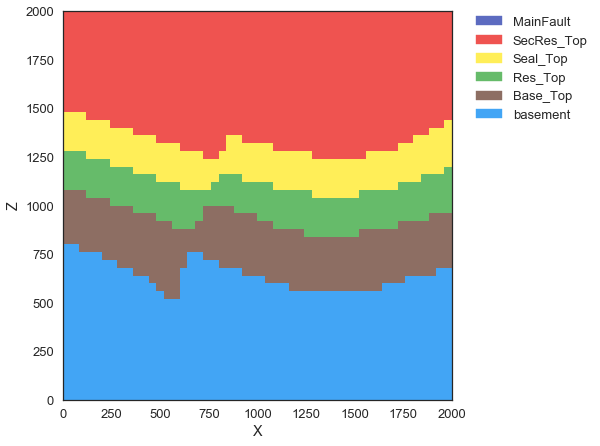

In [14]:
gp.plotting.plot_section(geo_data, lith_sol[0], int(resolution/2), plot_data=0)

In [15]:
# for setting up postional conditions to determine thicknesses and the like:
fw_th_point = 900 # distance of test point for thickness from footwall border of model 
                  # (e.g.: X = 2000 - 900 = 1100)
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)

# SAVING ORIGINAL Z-VALUES (so they are not overwritten and can be used a base for every iteration)    
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z']
base_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Base_Top']['Z']

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP
unc_f = 1
std_secres_top = 40 #* unc_f
std_seal_top = 60 #* unc_f
std_res_top = 80 #* unc_f
std_base_top = 100 #* unc_f
z_unc_secres_top = pymc.Normal('z_unc_secres_top', 0, 1./np.square(std_secres_top/rescale_f))
z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0/rescale_f, 1./np.square(std_seal_top/rescale_f))
z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./np.square(std_res_top/rescale_f))
z_unc_base_top = pymc.Normal('z_unc_base_top', 0, 1./np.square(std_base_top/rescale_f))

# SETTING FAULT OFFSET UNCERTAINTY
std_offset = 20 #150
# using SkewNormal, so that fault offset is much more like to vary to a higher offset and to stay as a normal fault
offset_unc = pymc.SkewNormal('offset_unc', -10/rescale_f, 1./np.square(std_offset/rescale_f), alpha=-2)
#offset_unc = pymc.SkewNormal('offset_unc', -100/rescale_f, 1./np.square(std_offset/rescale_f), alpha=-2)

In [16]:
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

# Footwall and hanging wall conditions
footwall = interp_data.geo_data_res.interfaces['fault side'] == 'footwall'
hanging_wall = interp_data.geo_data_res.interfaces['fault side'] == 'hanging wall'

# Combining hanging wall and formation conditions
HW_secres_top = np.logical_and(secres_top_cond,hanging_wall)
HW_seal_top = np.logical_and(seal_top_cond,hanging_wall)
HW_res_top = np.logical_and(res_top_cond,hanging_wall)
HW_base_top = np.logical_and(base_top_cond,hanging_wall)

Z variations top to bottom: 26.3841854893 56.4254749861 -19.9730275555 -101.736765543
Fault offset variation: -47.564336222


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to m

SPILL POINT AT: [ 1320.           920.           879.05067444]
LEAK POINT AT: [ 640.          960.          865.97457886]


C:\Users\Fabian\gempy\notebooks\prototype_notebooks\FabianThesis\Fabian_model_complete.py:236: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  mask[:,:,:bottom_z] = False


NUMBER OF TRAPS 4
Checking Section: 4
Checking Section: 13
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 13
Checking Section: 15
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 15
Checking Section: 18
Maximum trap volume: 23616000.0 m³


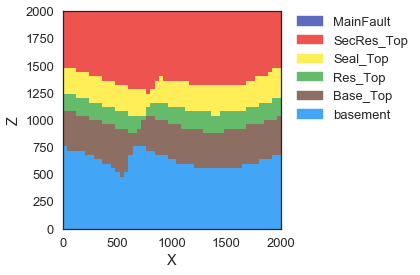

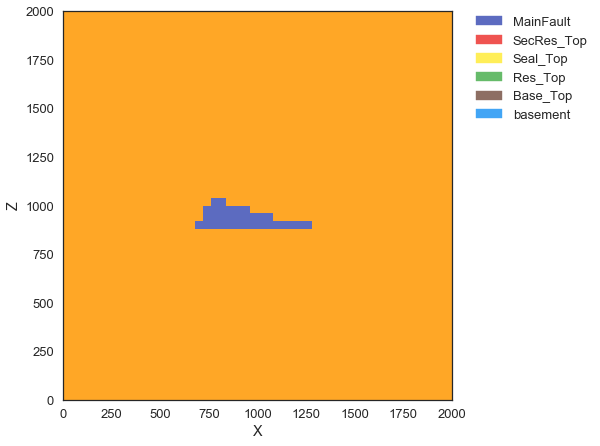

In [20]:
# PYMC MODEL FUNCTIONS

# Updating of interp_data points with new z-values resulting from z-positional uncertainty
# and including offset uncertainty:
@pymc.deterministic
def interp_unc(value=0, z_unc_secres_top=z_unc_secres_top, z_unc_seal_top=z_unc_seal_top,
               z_unc_res_top=z_unc_res_top, z_unc_base_top=z_unc_base_top, off_unc=offset_unc):
    # print('CHECK0:', res_z)
    new_z_secres_top = sec_res_z + z_unc_secres_top
    new_z_seal_top = seal_z + z_unc_seal_top
    new_z_res_top = res_z + z_unc_res_top
    new_z_base_top = base_z + z_unc_base_top

    # for offset uncertainty: additional change on hanging wall (HW):
    HW_new_z_secres_top = new_z_secres_top + off_unc
    HW_new_z_seal_top = new_z_seal_top + off_unc
    HW_new_z_res_top = new_z_res_top + off_unc
    HW_new_z_base_top = new_z_base_top + off_unc

    print('Z variations top to bottom:', z_unc_secres_top * rescale_f,
          z_unc_seal_top * rescale_f, z_unc_res_top * rescale_f, z_unc_base_top * rescale_f)
    print('Fault offset variation:', off_unc * rescale_f)

    # FOOTWALL UNCERTAINTY
    interp_data.geo_data_res.interfaces.loc[secres_top_cond, 'Z'] = new_z_secres_top
    interp_data.geo_data_res.interfaces.loc[seal_top_cond, 'Z'] = new_z_seal_top
    interp_data.geo_data_res.interfaces.loc[res_top_cond, 'Z'] = new_z_res_top
    interp_data.geo_data_res.interfaces.loc[base_top_cond, 'Z'] = new_z_base_top

    # HANGING WALL UNCERTAINTY (incl. offset)
    interp_data.geo_data_res.interfaces.loc[HW_secres_top, 'Z'] = HW_new_z_secres_top
    interp_data.geo_data_res.interfaces.loc[HW_seal_top, 'Z'] = HW_new_z_seal_top
    interp_data.geo_data_res.interfaces.loc[HW_res_top, 'Z'] = HW_new_z_res_top
    interp_data.geo_data_res.interfaces.loc[HW_base_top, 'Z'] = HW_new_z_base_top

    # print('CHECK3:', interp_data.geo_data_res.interfaces)
    return interp_data


# Calculating formation thickness based on z-difference between a bottom and top point on the footwall (fw)

# This is done using interp_data, where X,Y and Z-values are rescaled according to the rescaling_factor.
# Value[1] of extent_rescaled equals the maximum extent of model (here: 2000).
# So if we want to find the rescaled chosen X-position (here: 1100),
# we simply calculate 2000-fw_th_point(here:900) rescaled (see fw_x)
# Y_mid defines that we are looking at a central position (in y-direction) in the model.
# The difference in z between two points has to be rescaled to the original scale again.
# rescale_f = interp_data.rescaling_factor

# Reservoir thickness
@pymc.deterministic
def res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point / rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000 / rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid]
    fw_rb_z = points_fw[base_top_cond]['Z'].values * rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values * rescale_f
    return np.abs(fw_sb_z - fw_rb_z)


# Seal thickness
@pymc.deterministic
def seal_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point / rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000 / rescale_f))
    # .extent[1] = 'X'-max; .extent[3] = 'Y'-max
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid]
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values * rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values * rescale_f
    return np.abs(fw_r2b_z - fw_sb_z)


# Secondary reservoir thickness
@pymc.deterministic
def sec_res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point / rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000 / rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid]
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values * rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values * rescale_f
    return np.abs(fw_ob_z - fw_r2b_z)


# Volumetric calculation
@pymc.deterministic
def structural_model(interp_data_M=interp_unc, seal_th=seal_th,
                     lh=lith_holder, fh=fault_holder, idh=interp_holder, seal_n=seal_n, 
                     res_n=res_n, print_figures=True):
    try:
        lith_sol, fault_sol = gp.compute_model(interp_data_M)
        lith_block = lith_sol[0]
        fault_block = fault_sol[0]
        seal_surf_v, seal_surf_s = gp.get_surfaces( \
            interp_data=interp_data_M, potential_lith=lith_sol[1],
            potential_fault=fault_sol[1], n_formation=seal_n)
        max_vol, trap, SSF, trap_control = fm.max_trap_vol(interp_data_M, lith_block, fault_block, seal_surf_v, seal_th)
        print("Maximum trap volume: %s m³" % max_vol)
        if print_figures:
            plt.figure(1)
            gp.plotting.plot_section(geo_data, lith_sol[0], int(resolution / 2), plot_data=0)
            plt.figure(2)
            gp.plotting.plot_section(geo_data, trap, int(resolution / 2), plot_data=0)
        return lith_sol, fault_sol, max_vol, trap, SSF, trap_control
        # return max_vol, SSF, trap_control

    except np.linalg.linalg.LinAlgError as err:
        # In case of LinAlgError, use original model
        print('LinAlgError occurred!')
        lith_sol = lh
        fault_sol = fh
        lith_block = lith_sol[0]
        fault_block = fault_sol[0]
        seal_surf_v, seal_surf_s = gp.get_surfaces(
            interp_data=interp_data_M, potential_lith=lith_sol[1],
            potential_fault=fault_sol[1], n_formation=seal_n)
        max_vol, trap, SSF, trap_control = fm.max_trap_vol(idh, lith_block, fault_block, seal_surf_v, seal_thn)
        print("Maximum trap volume: %s m³" % max_vol)
        return lith_sol, fault_sol, max_vol, trap, SSF, trap_control
        # return max_vol, SSF, trap_control

    ### RETURN INDICES:
    ### 0 = lith_sol
    ### 1 = fault_sol
    ### 2 = max_vol (maximum trap volume)
    ### 3 = trap (block)
    ### 4 = SSF (Shale Smear Factor)
    ### 5 = trap_control (controling mechanism for max trap volume)

In [22]:
iterations = 10

In [23]:
model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, structural_model, res_th, seal_th, sec_res_th])

In [27]:
M = pymc.MCMC(model)
#M = pymc.MCMC(model,db= "hdf5" , dbname= "D:/PyMC_DataBase/prior_model_noBlocks_SSFc_3_1000iter_2017_11_12")
M.sample(iter=iterations)

SPILL POINT AT: [ 1360.          920.          844.3863678]
LEAK POINT AT: [ 640.          960.          870.83137512]


C:\Users\Fabian\gempy\notebooks\prototype_notebooks\FabianThesis\Fabian_model_complete.py:236: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  mask[:,:,:bottom_z] = False


IndexError: index 50 is out of bounds for axis 1 with size 50

In [25]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
offset_unc_trace = M.trace('offset_unc')[:]
#fault_sealing_trace = M.trace('fault_sealing_unc')[:]
interp_trace = M.trace('interp_unc')[:]
#over_jux_area_trace = M.trace('over_jux_area')[:] 

fw_res_th_trace = M.trace('res_th')[:]
fw_seal_th_trace = M.trace('seal_th')[:]
fw_sec_res_th_trace = M.trace('sec_res_th')[:]

structural_model_trace = M.trace('structural_model')[:]
max_volume_trace = structural_model_trace[:,2]
SSF_trace = structural_model_trace[:,4]
trap_control_trace = structural_model_trace[:,5]

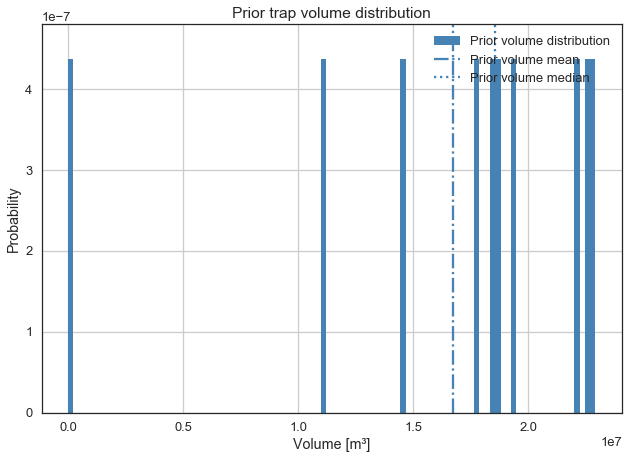

In [26]:
_hist1 = plt.hist(max_volume_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
plt.vlines(max_volume_trace.mean(), 0, 1.1 * np.max(_hist1[0]), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(max_volume_trace), 0, 1.1 * np.max(_hist1[0]), label="Prior volume median", linestyles=":", color = "steelblue")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")